In [1144]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

### Download sequences

In [1145]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   210  100   210    0     0    171      0  0:00:01  0:00:01 --:--:--   171
100 32.7M  100 32.7M    0     0  4763k      0  0:00:07  0:00:07 --:--:-- 7505k
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   216  100   216    0     0    413      0 --:--:-- --:--:-- --:--:--   412
100 12.7M  100 12.7M    0     0  2515k      0  0:00:05  0:00:05 --:--:-- 3529k
+ bash scripts/

In [1146]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

In [1147]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [1148]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [1149]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [1150]:
df.reason.value_counts()

N                             270452
X                             192010
A[B.1.1.7]                     35809
A[B.1.617.2]                   35309
Y                              24034
                               ...  
A[KONTAKTMITENGL.MUTATION]         0
A[N501Y/E484K]                     0
A[E484E/N501N/P681R]               0
A[B1.627.2]                        0
A[E484K/N501Y/P681R]               0
Name: reason, Length: 206, dtype: int64

In [1151]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d.lineage = d.lineage.cat.add_categories(['Other'])
d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Other"
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage.cat.remove_unused_categories(), dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other
bundesland        date                                       
Baden-Württemberg 2021-11-01     0       0     0     0    142
                  2021-11-02     0       0     0     0    350
                  2021-11-03     0       0     0     0    704
                  2021-11-04     0       0     0     0   1044
                  2021-11-05     0       0     0     0   1210
...                            ...     ...   ...   ...    ...
Thüringen         2022-02-08     1       2     0     0      0
                  2022-02-09     0       0     3     0      0
                  2022-02-10     1       1     0     0      0
                  2022-02-11     0       0     0     0      0
                  2022-02-13     0       0     0     0      0

[1664 rows x 5 columns]

In [1152]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [1153]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [1154]:
cases_raw = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [1155]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-21   
                                    2020-03-13  2020-03-19   
                                    2020-03-16  2020-03-19   
            A35-A59      M          2020-03-16  2020-03-14   
...                                                    ...   
16077       A00-A04      W          2022-02-16  2022-02-16   
            A15-A34      W          2022-02-16  2022-02-16   
            A80+         W          2022-02-16  2022-02-16   
            A05-A14      W          2022-02-16  2022-02-16   
            A35-A59      W          2022-02-16  2022-02-16   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
            A35-A59      M          2020-03-16                     1   
...                                                              ...   
16077       A00-A04      W          2022-02-16                     0   
            A15-A34      W          2022-02-16                     0   
            A80+         W          2022-02-16                     0   
            A05-A14      W          2022-02-16                     0   
            A35-A59      W          2022-02-16                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
            A35-A59      M          2020-03-16          0              -9   
...                                                   ...             ...   
16077       A00-A04      W          2022-02-16          1              -9   
            A15-A34      W          2022-02-16          1              -9   
            A80+         W          2022-02-16          1              -9   
            A05-A14      W          2022-02-16          1              -9   
            A35-A59      W          2022-02-16          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
            A35-A59      M          2020-03-16           0           1   
...                                                    ...         ...   
16077       A00-A04      W          2022-02-16          -9           3   
            A15-A34      W          2022-02-16          -9          17   
            A80+         W          2022-02-16          -9           2   
            A05-A14      W          2022-02-16          -9          15   
            A35-A59      W          2022-02-16          -9          26   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

In [1156]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2021-12-27":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

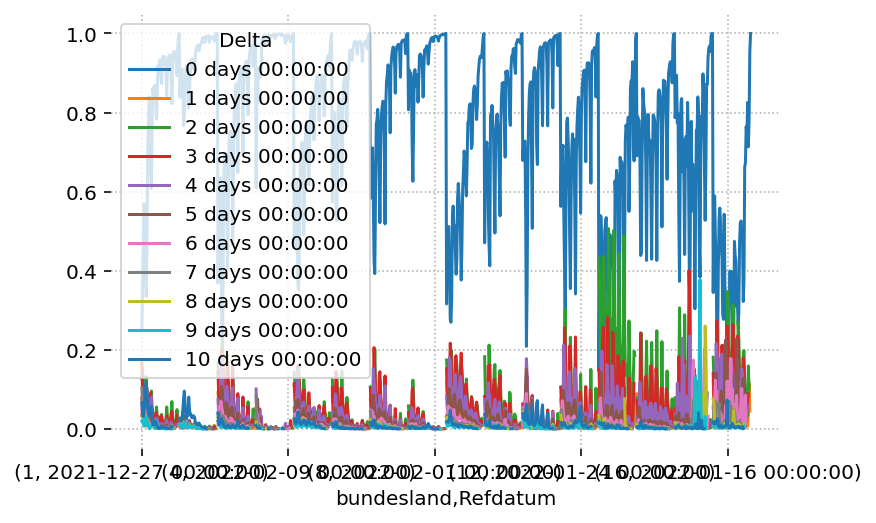

In [1157]:
f.plot()

In [1158]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [1159]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [1160]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Mon             0.753036         0.786710         0.835678         0.869455   
Tue             0.833421         0.856341         0.881500         0.912576   
Wed             0.851418         0.862421         0.896588         0.915304   
Thu             0.863075         0.884411         0.904824         0.920809   
Fri             0.854865         0.872867         0.891893         0.914470   
Sat             0.783766         0.800127         0.841040         0.891448   
Sun             0.736722         0.764077         0.834508         0.884217   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Mon             0.905598         0.918408         0.928546         0.950694   
Tue             0.927261         0.938572         0.955718         0.968779   
Wed             0.932028         0.951050         0.964798         0.975461   
Thu             0.939890         0.957195         0.969070         0.973593   
Fri             0.939065         0.956287         0.963014         0.972472   
Sat             0.923043         0.935897         0.953494         0.958148   
Sun             0.908734         0.932333         0.940018         0.920335   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Mon             0.961558         0.971490               1.0  
Tue             0.977419         0.981330               1.0  
Wed             0.980379         0.985764               1.0  
Thu             0.981543         0.980849               1.0  
Fri             0.975746         0.977565               1.0  
Sat             0.941977         0.968672               1.0  
Sun             0.955328         0.965956               1.0

In [1161]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [1162]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [1163]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.997473  0.996596  0.994051  0.991834  0.980021   
Bayern                  0.989096  0.984018  0.971065  0.953984  0.910582   
Berlin                  0.980038  0.980269  0.974871  0.956125  0.881322   
Brandenburg             0.989273  0.985843  0.979969  0.962662  0.926125   
Bremen                  0.997723  0.999035  0.997782  0.994044  0.990822   
Hamburg                 0.978323  0.977414  0.977532  0.963100  0.933698   
Hessen                  0.997090  0.995109  0.994039  0.987408  0.972522   
Mecklenburg-Vorpommern  0.993840  0.989905  0.984268  0.970321  0.953269   
Niedersachsen           0.990647  0.987066  0.978535  0.957456  0.922723   
Nordrhein-Westfalen     0.985107  0.980257  0.973281  0.957023  0.917319   
Rheinland-Pfalz         0.996195  0.992330  0.988309  0.974913  0.942527   
Saarland                0.993515  0.992198  0.991798  0.981083  0.969837   
Sachsen                 0.997479  0.995346  0.994723  0.986187  0.970108   
Sachsen-Anhalt          0.993167  0.979756  0.982823  0.927800  0.855977   
Schleswig-Holstein      0.977419  0.975461  0.969070  0.956287  0.923043   
Thüringen               0.991364  0.985692  0.959942  0.925456  0.816045   

                               5         6         7         8  
Baden-Württemberg       0.958698  0.953147  0.967359  0.960411  
Bayern                  0.855551  0.771540  0.762064  0.736053  
Berlin                  0.812847  0.908847  0.917727  0.924685  
Brandenburg             0.844193  0.855202  0.861150  0.850769  
Bremen                  0.981891  0.941369  0.953142  0.974557  
Hamburg                 0.933243  0.938965  0.953379  0.960589  
Hessen                  0.951212  0.918865  0.927199  0.917192  
Mecklenburg-Vorpommern  0.908337  0.786721  0.706650  0.665253  
Niedersachsen           0.838093  0.821707  0.841639  0.835929  
Nordrhein-Westfalen     0.858198  0.842686  0.839178  0.817831  
Rheinland-Pfalz         0.889338  0.888819  0.895984  0.884825  
Saarland                0.928451  0.820694  0.873871  0.861760  
Sachsen                 0.928889  0.911857  0.906289  0.847113  
Sachsen-Anhalt          0.740593  0.823730  0.815538  0.792506  
Schleswig-Holstein      0.884217  0.835678  0.856341  0.851418  
Thüringen               0.782441  0.706166  0.649973  0.567073

In [1164]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [1165]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,"2021-11-01":,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2140        2958        4432        4620   
Bayern                        5939        7032        9174        8940   
Berlin                        1272        1326        1486        1444   
Brandenburg                    808         979        1071        1061   
Bremen                          79          89          69          62   
Hamburg                        313         442         542         531   
Hessen                        1190        1596        1710        1580   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1185        1451        1674        1369   
Nordrhein-Westfalen           2510        3361        4297        4374   
Rheinland-Pfalz                642         990        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2835        3666        3470        3306   
Sachsen-Anhalt                 647         856         721         738   
Schleswig-Holstein             337         390         366         354   
Thüringen                     1797        1399        1453        1567   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5070        4130        2277        4414   
Bayern                        9235        8788        7211        9313   
Berlin                        1467         924         720        2230   
Brandenburg                   1184        1118         972        1252   
Bremen                          55          55          31          60   
Hamburg                        562         469         411         468   
Hessen                        1687        1315        1091        1470   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1400        1165         843        1621   
Nordrhein-Westfalen           4069        3720        2855        4324   
Rheinland-Pfalz               1027         809         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3463        3191        2645        4422   
Sachsen-Anhalt                 729         658         899         670   
Schleswig-Holstein             436         382         298         448   
Thüringen                     1430        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-02-07  2022-02-08  \
bundesland                                      ...                           
Baden-Württemberg             7140        7761  ...       23097       34190   
Bayern                       11225       12124  ...       28679       39954   
Berlin                        1911        2377  ...       10530       11709   
Brandenburg                   1494        1682  ...        6357        9238   
Bremen                         143          95  ...        2179        1429   
Hamburg                        533         578  ...        4766        5245   
Hessen                        1791        2066  ...       15900       19826   
Mecklenburg-Vorpommern         596         468  ...        2081        4562   
Niedersachsen                 1754        2163  ...       13218       19466   
Nordrhein-Westfalen           5241        5411  ...       42770       49982   
Rheinland-Pfalz               1139        1329  ...        9204        9674   
Saarland                       273         301  ...        1166        2978   
Sachsen                       5792        5973  ...        7055       11884   
Sachsen-Anhalt                1019        1178  ...        4197        6640   
Schleswig-Holstein             486         542  ...        3455       

In [1166]:
cases_land.sum(0)

Refdatum
2021-11-01     22239
2021-11-02     27086
2021-11-03     32200
2021-11-04     31572
2021-11-05     32543
               ...  
2022-02-12    116185
2022-02-13     70737
2022-02-14    146422
2022-02-15    202548
2022-02-16    156505
Length: 108, dtype: int64

In [1167]:
clip = 1
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2140        2958        4432        4620   
Bayern                        5939        7032        9174        8940   
Berlin                        1272        1326        1486        1444   
Brandenburg                    808         979        1071        1061   
Bremen                          79          89          69          62   
Hamburg                        313         442         542         531   
Hessen                        1190        1596        1710        1580   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1185        1451        1674        1369   
Nordrhein-Westfalen           2510        3361        4297        4374   
Rheinland-Pfalz                642         990        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2835        3666        3470        3306   
Sachsen-Anhalt                 647         856         721         738   
Schleswig-Holstein             337         390         366         354   
Thüringen                     1797        1399        1453        1567   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5070        4130        2277        4414   
Bayern                        9235        8788        7211        9313   
Berlin                        1467         924         720        2230   
Brandenburg                   1184        1118         972        1252   
Bremen                          55          55          31          60   
Hamburg                        562         469         411         468   
Hessen                        1687        1315        1091        1470   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1400        1165         843        1621   
Nordrhein-Westfalen           4069        3720        2855        4324   
Rheinland-Pfalz               1027         809         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3463        3191        2645        4422   
Sachsen-Anhalt                 729         658         899         670   
Schleswig-Holstein             436         382         298         448   
Thüringen                     1430        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-02-06  2022-02-07  \
bundesland                                      ...                           
Baden-Württemberg             7140        7761  ...       12297       23097   
Bayern                       11225       12124  ...       22283       28679   
Berlin                        1911        2377  ...         785       10530   
Brandenburg                   1494        1682  ...        1516        6357   
Bremen                         143          95  ...         671        2179   
Hamburg                        533         578  ...        2000        4766   
Hessen                        1791        2066  ...        8322       15900   
Mecklenburg-Vorpommern         596         468  ...        1264        2081   
Niedersachsen                 1754        2163  ...        6014       13218   
Nordrhein-Westfalen           5241        5411  ...       21205       42770   
Rheinland-Pfalz               1139        1329  ...        2171        9204   
Saarland                       273         301  ...         933        1166   
Sachsen                       5792        5973  ...        3306        7055   
Sachsen-Anhalt                1019        1178  ...        3291        4197   
Schleswig-Holstein             486         542  ...        1394       

In [1168]:
C = cases_land.values

In [1169]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [1170]:
from genomicsurveillance.misc import fused_basis
B0 = fused_basis(C.shape[1]+clip, inc=10, fuse=5) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 

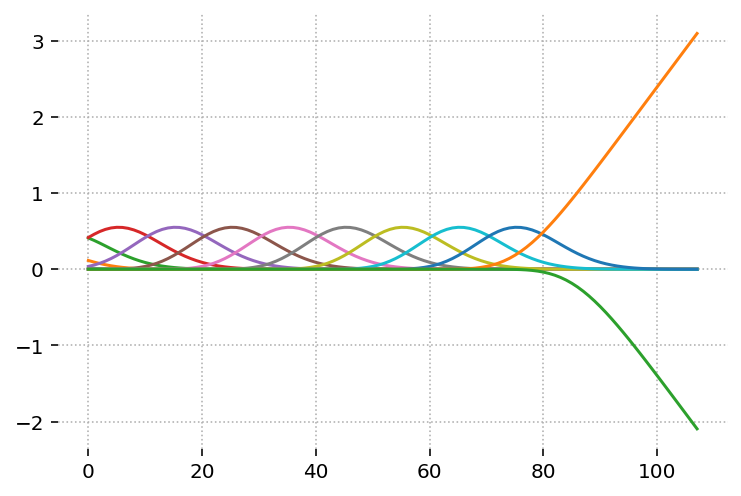

In [1171]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

In [1172]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [1173]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [1174]:
from numpyro.infer import Trace_ELBO

In [1175]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

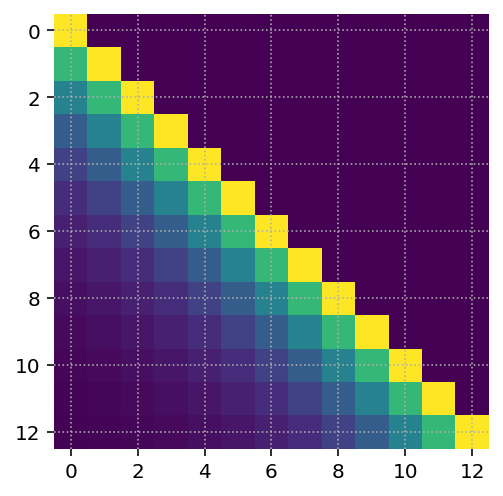

In [1176]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.667
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

In [1177]:
model = MultiLineageTimeShift(
    CC,
    GG,    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)]),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.01,
    b0_scale=0.3,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=100., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':15000, 'lr':0.005, 'lrd': 0.2 ** (1/10000), 'num_samples': 100}

)

In [1178]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 15,000 | 0 %
SVI step 1,000 / 15,000 | 7 %
SVI step 2,000 / 15,000 | 13 %
SVI step 3,000 / 15,000 | 20 %
SVI step 4,000 / 15,000 | 27 %
SVI step 5,000 / 15,000 | 33 %
SVI step 6,000 / 15,000 | 40 %
SVI step 7,000 / 15,000 | 47 %
SVI step 8,000 / 15,000 | 53 %
SVI step 9,000 / 15,000 | 60 %
SVI step 10,000 / 15,000 | 67 %
SVI step 11,000 / 15,000 | 73 %
SVI step 12,000 / 15,000 | 80 %
SVI step 13,000 / 15,000 | 87 %
SVI step 14,000 / 15,000 | 93 %


Text(0, 0.5, 'ELBO')

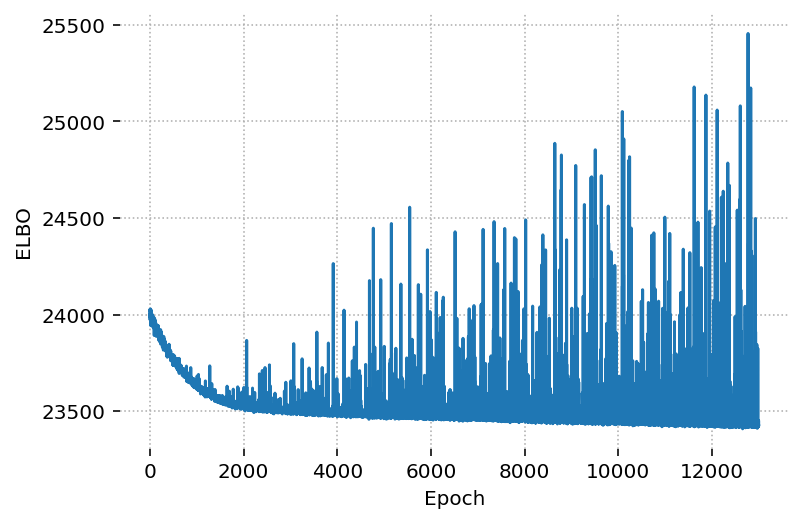

In [1179]:
plt.plot(model.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((None, model.loss[2000]))

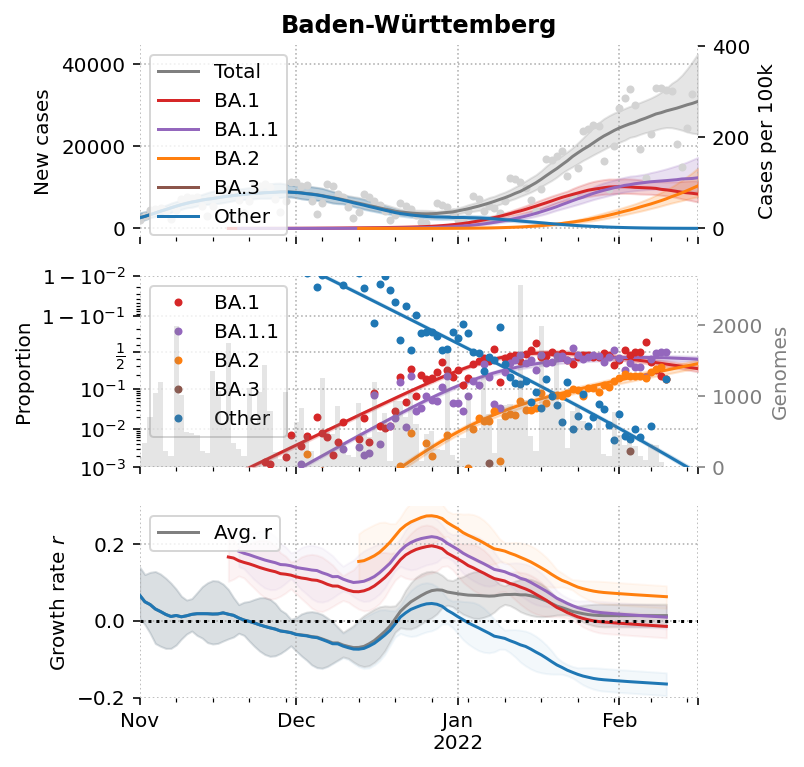

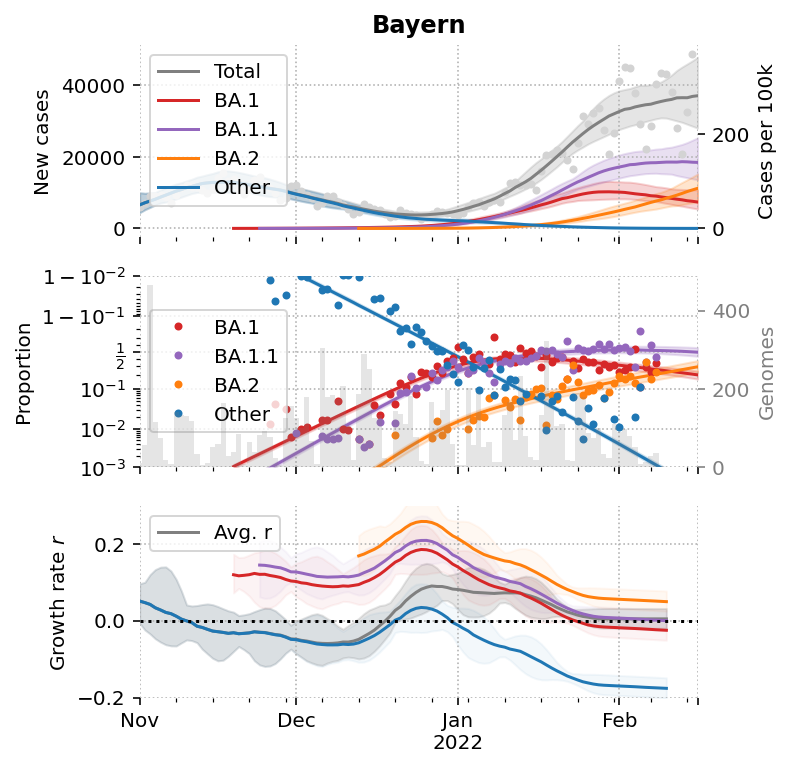

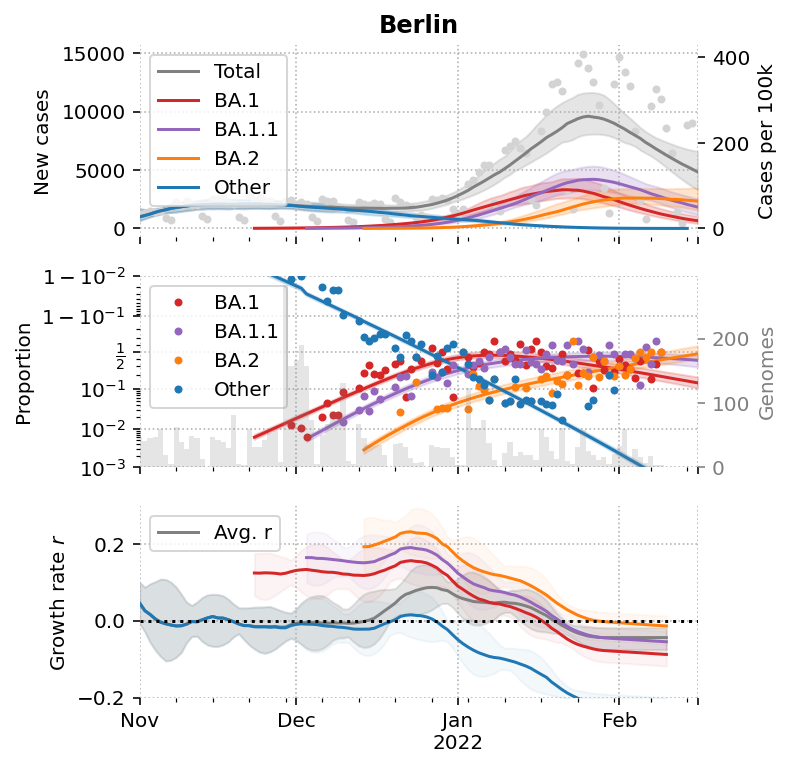

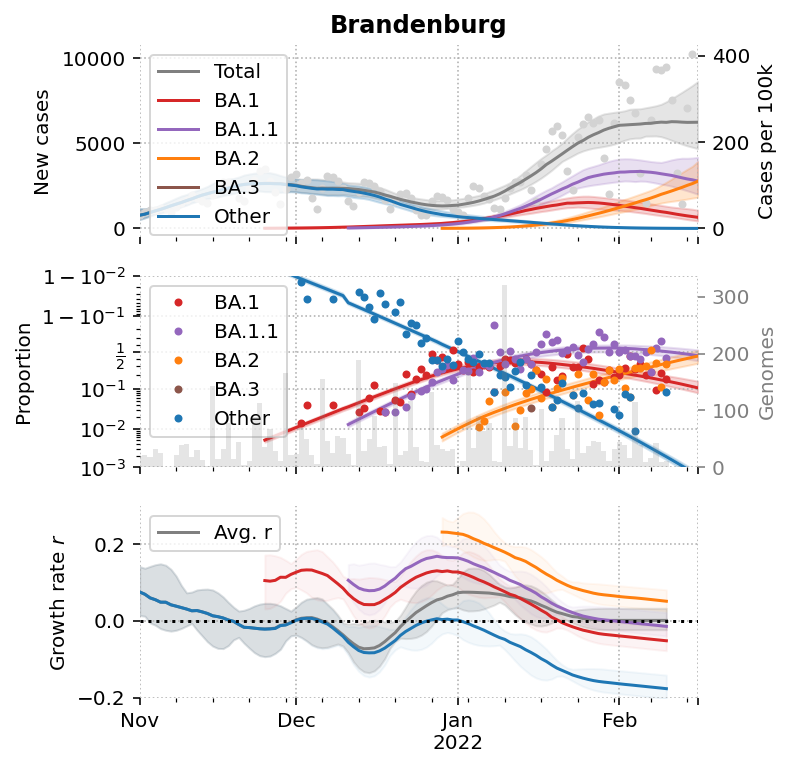

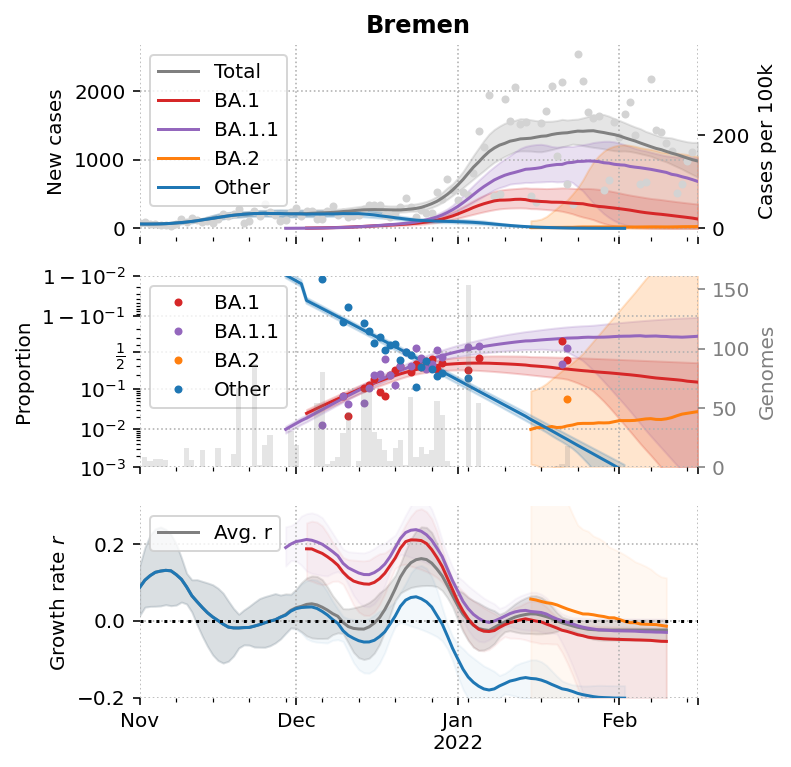

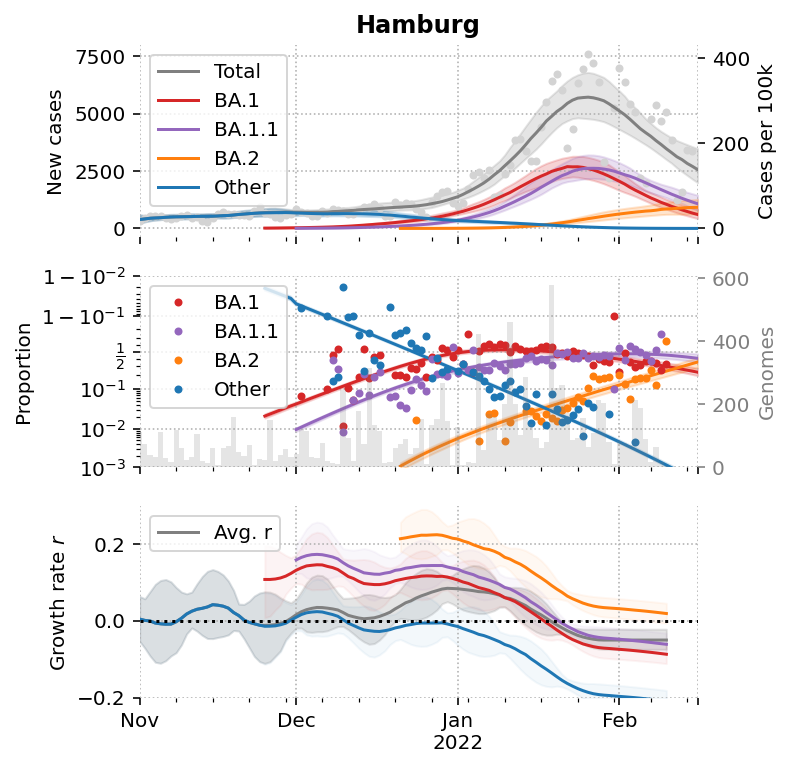

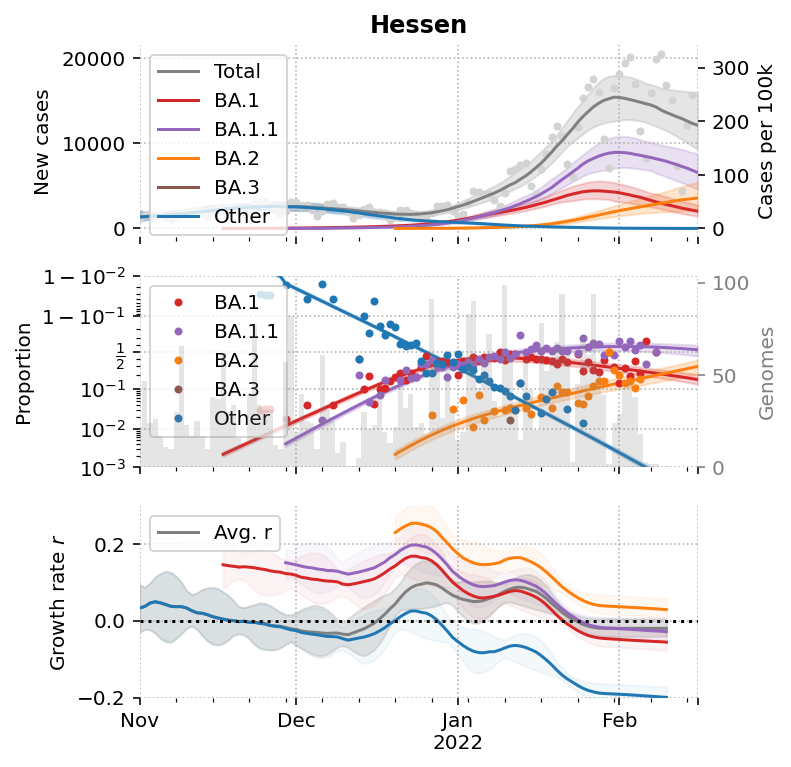

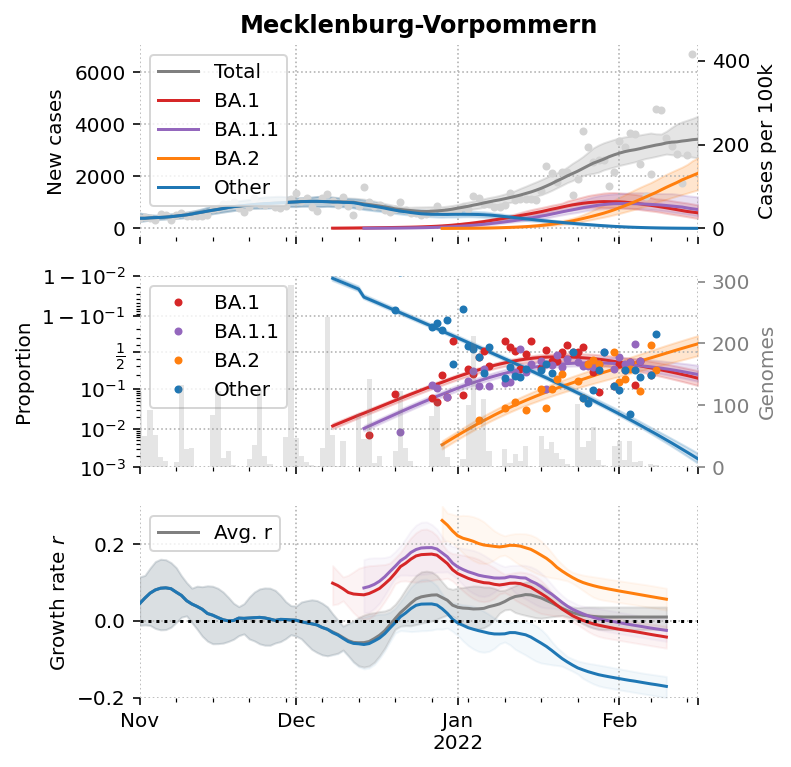

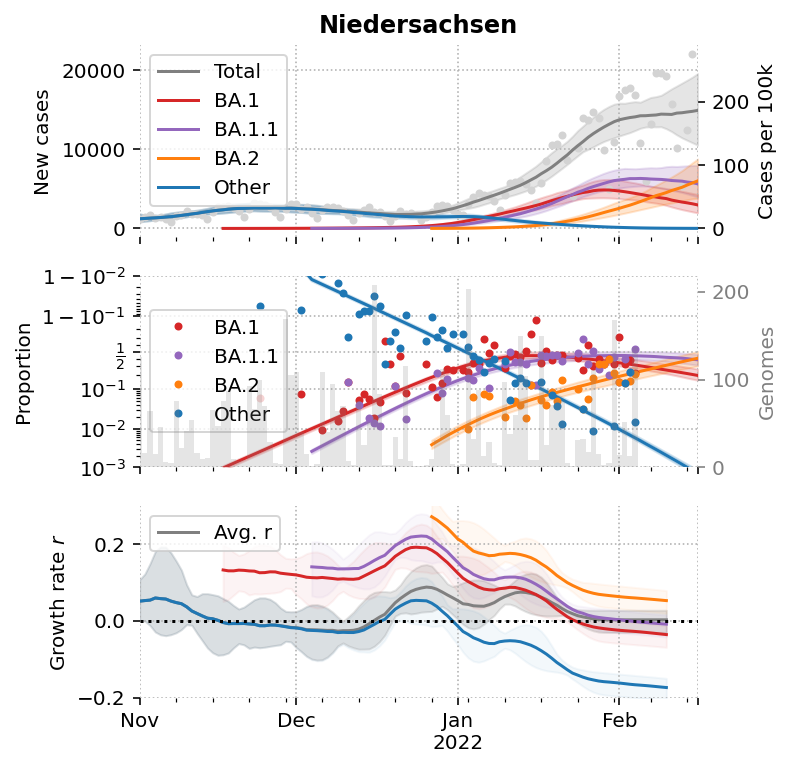

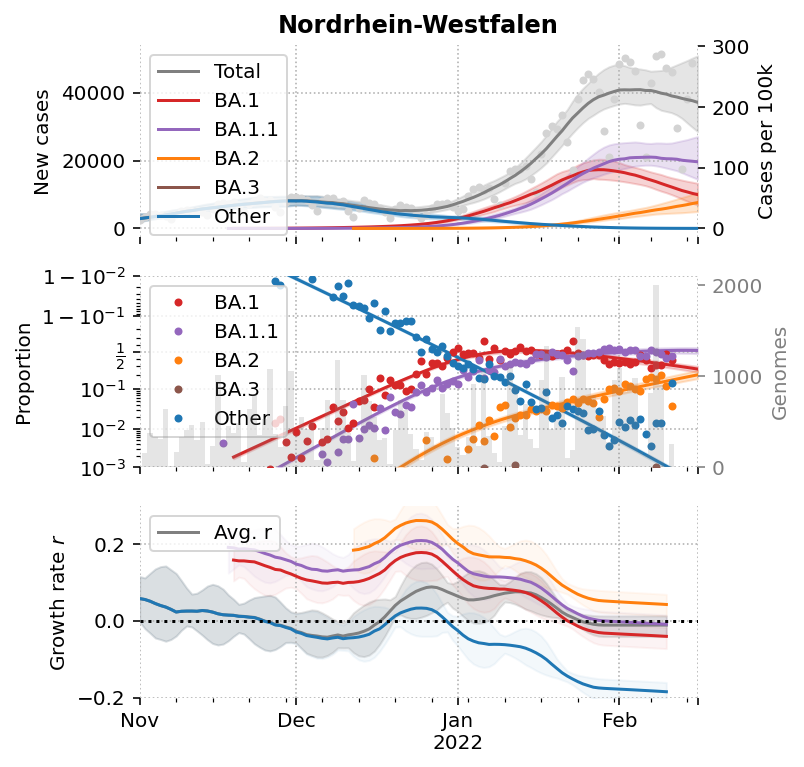

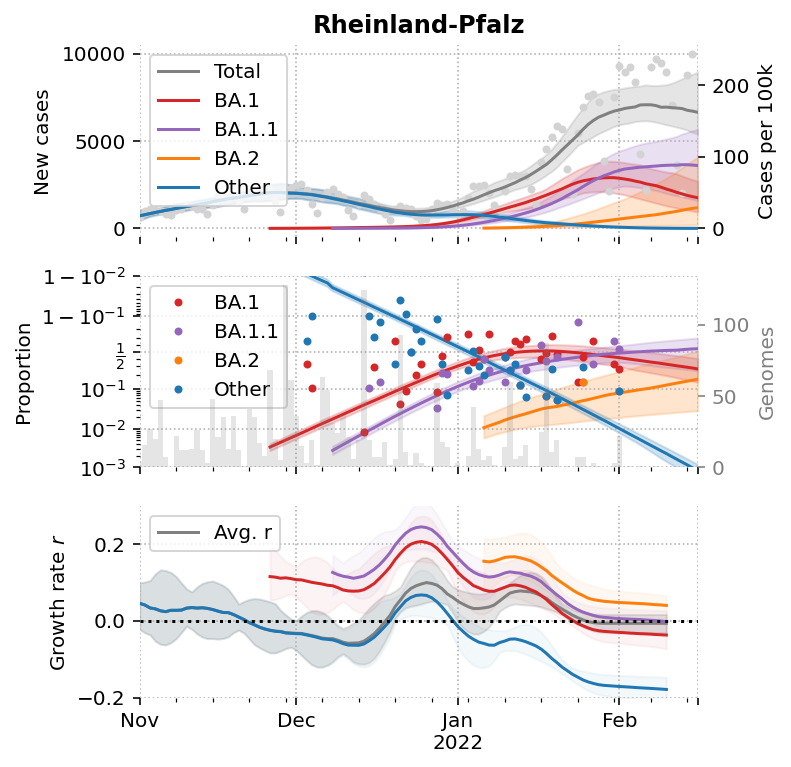

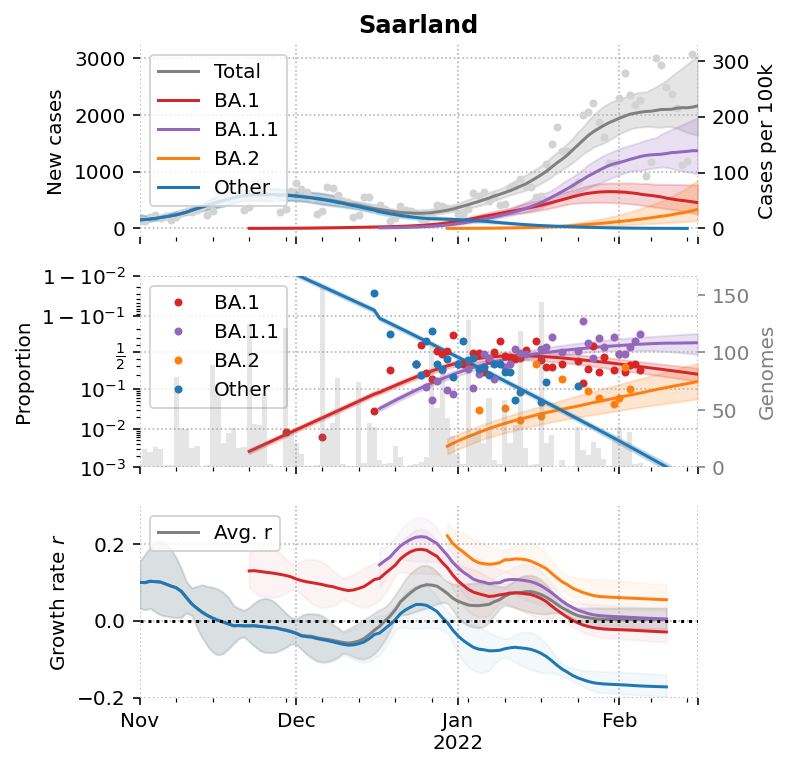

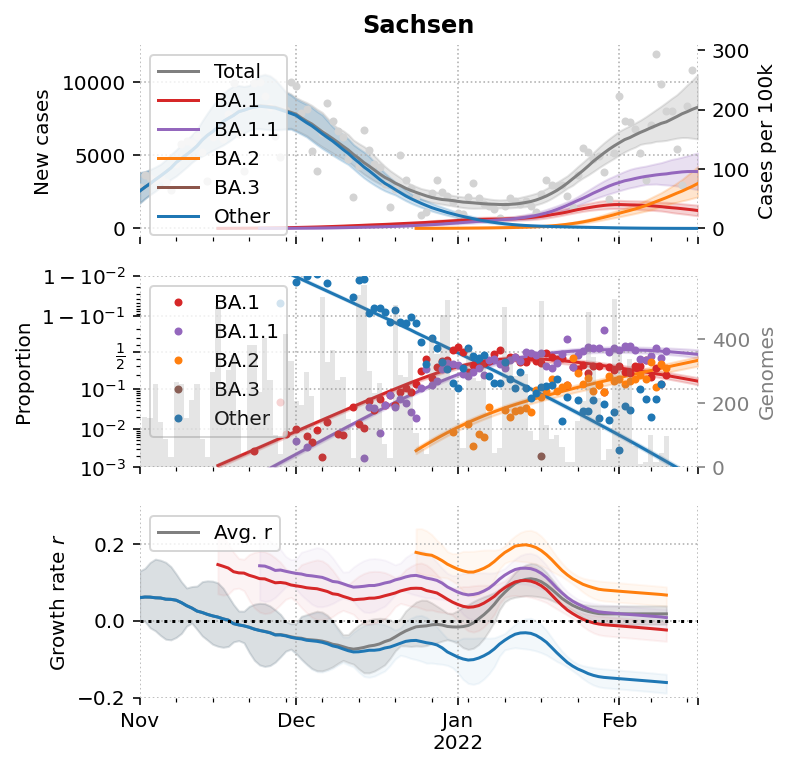

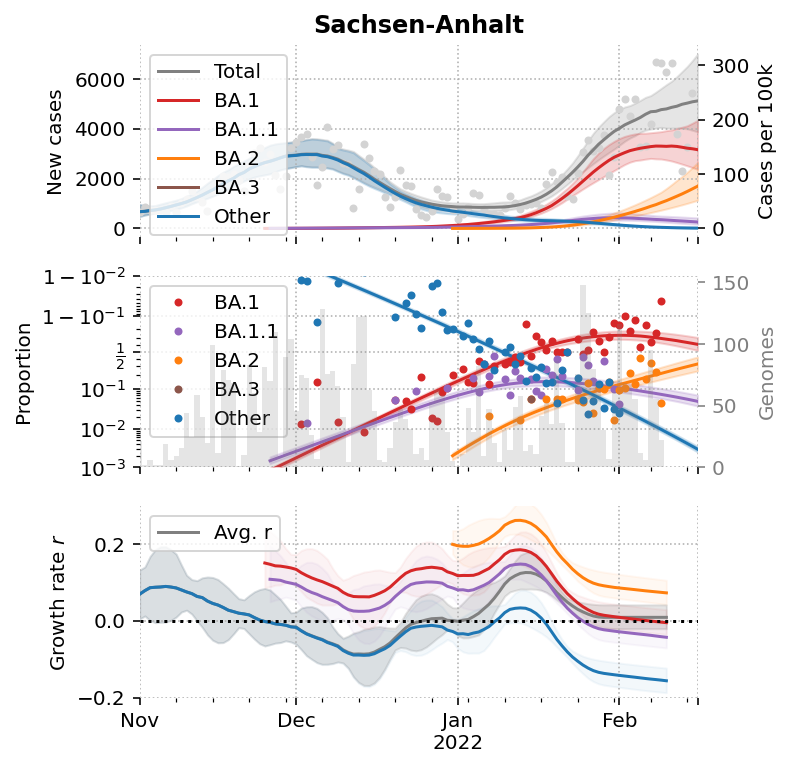

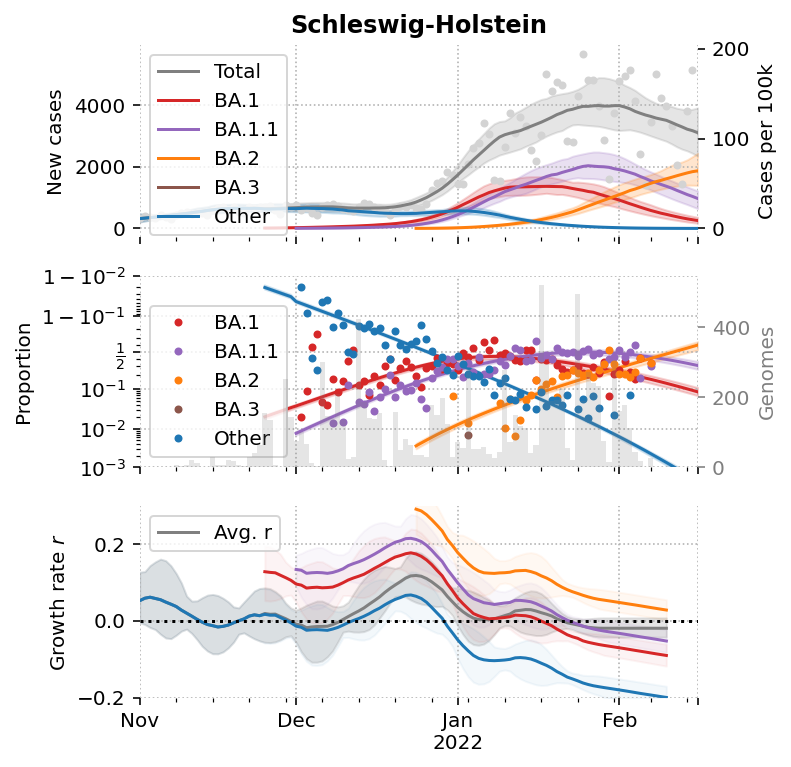

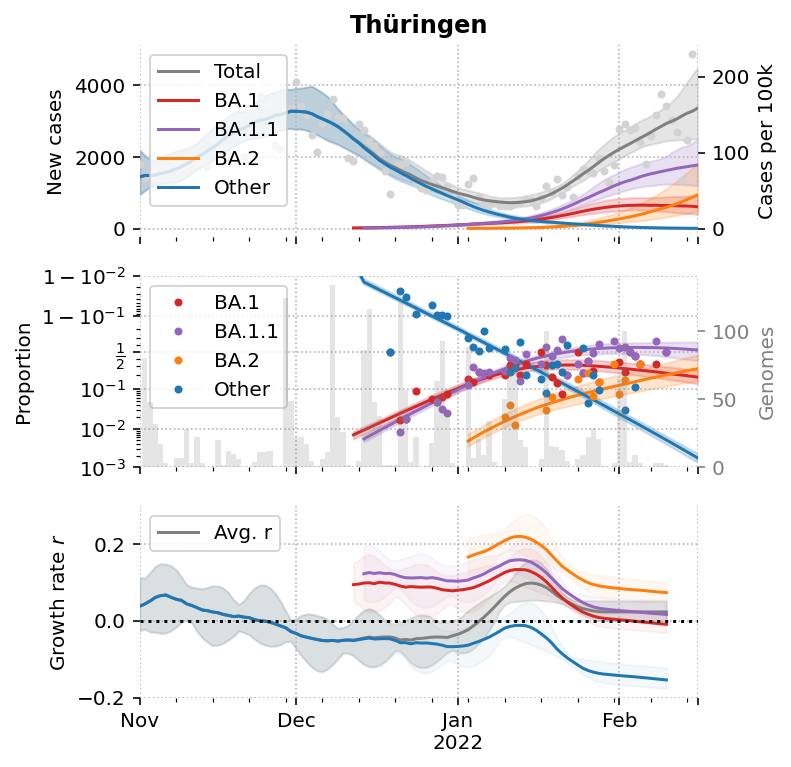

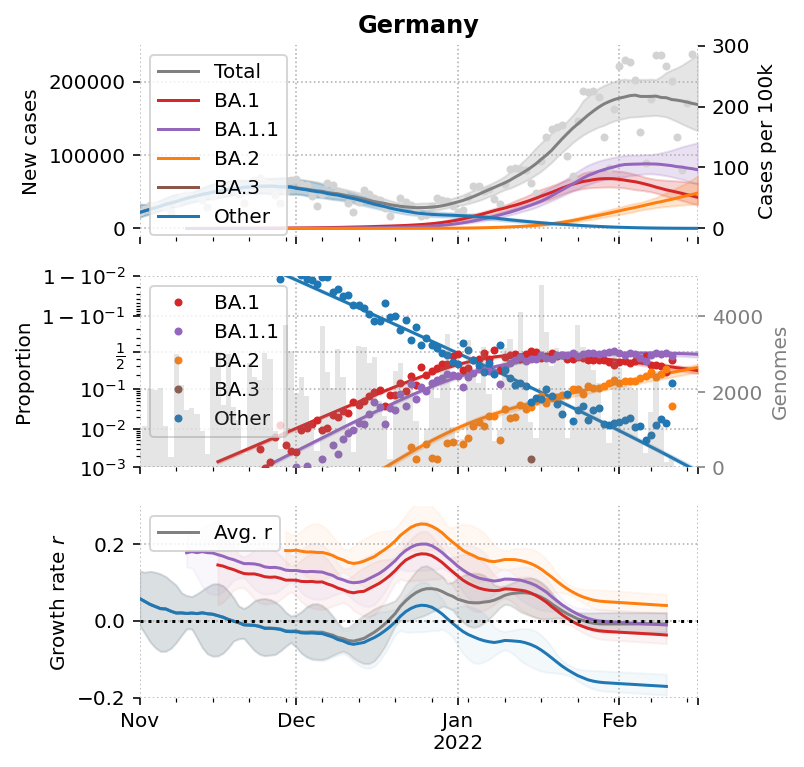

In [1180]:
#from genomicsurveillance.plots.england import plot_lad, 
from genomicsurveillance.plots.england import plot_median_and_ci
for i,r in enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 1)[0]
    plot_lad(model, i, CC, GG, seq_index, start_date="2021-11-01", show_start_date="2021-11-01",
        lin = w,
        labels = genomes.columns[w],
        lin_colors=np.array(['C3',"C4","C1", "C5" ,"C0", "C9","C0"])[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
            figsize=(5,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    #ax[0].set_yscale('log')
    #ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-3,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")

In [1181]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

1.0

In [1182]:
model.posterior.keys()

dict_keys(['b1', 'b_scale_lin', 'bc0', 'beta1', 'c1', 't', 'b0'])

Text(0.5, 1.0, 'Germany')

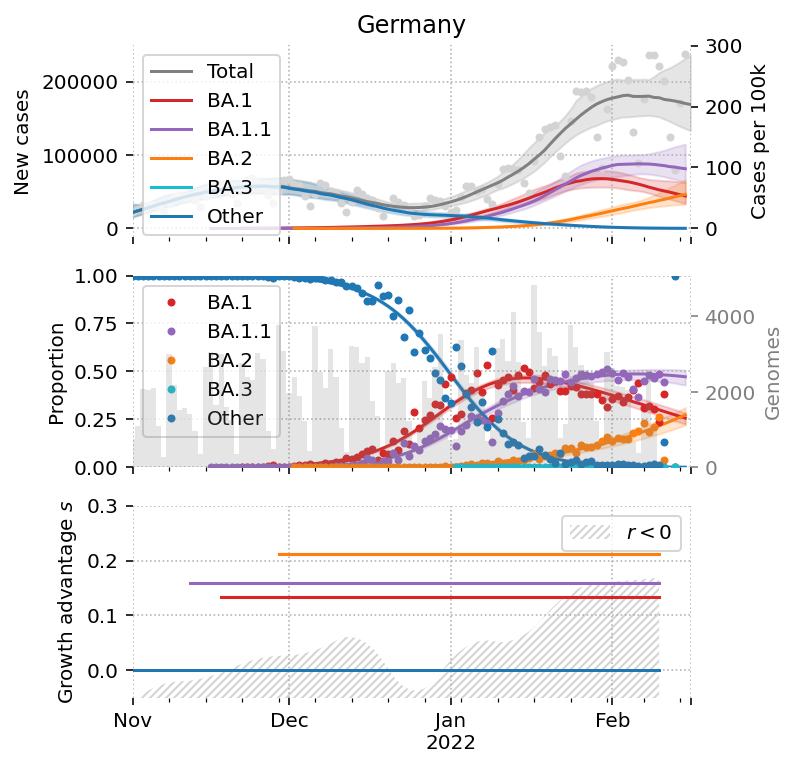

In [1183]:
w = np.arange(genomes.shape[-1])
plot_lad(model, -1, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
            bleed_left = 1,
             bleed_right=6,
             show_Rt = False,
             plot_s= True
            )
plt.gcf().get_axes()[2].set_ylim(-0.05,0.3)
plt.gcf().get_axes()[0].set_title("Germany")

In [1184]:
λ = model.get_lambda_lineage().mean(0) / model.population[:,np.newaxis, np.newaxis]

In [1185]:
λ.shape

(17, 108, 5)

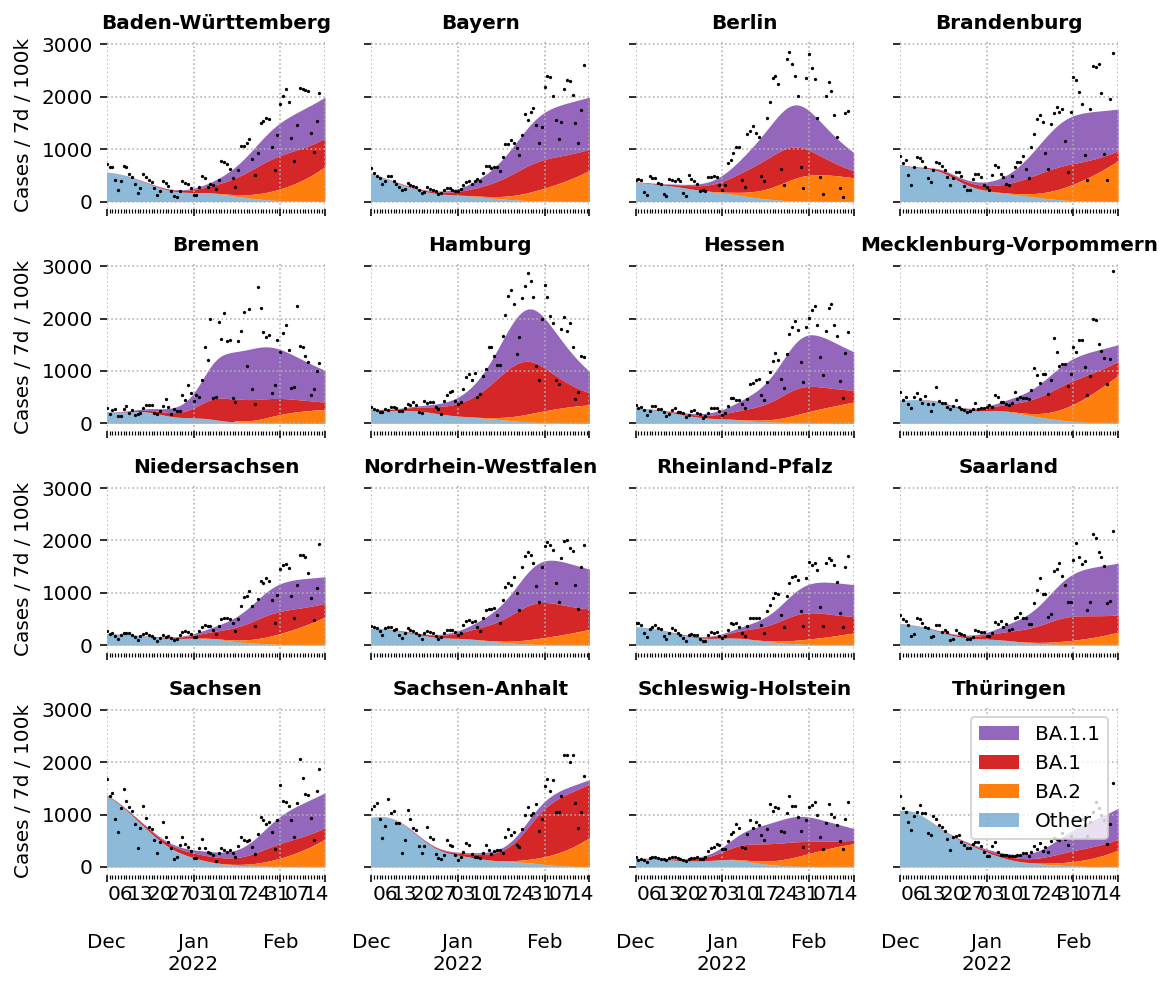

In [1186]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(cases_land.index):
    y = pd.DataFrame(λ[i,:,:], columns=genomes.columns, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = y[["Other","BA.2","BA.1","BA.1.1","BA.3"]].cumsum(1) * 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    (cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    ax[i].fill_between(y.index, y["BA.1"], y["BA.1.1"], color='C4', alpha=1, lw=0, label="BA.1.1")
    ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    ax[i].fill_between(y.index, y["Other"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    ax[i].fill_between(y.index, y["Other"], color='C0', alpha=.5, lw=0, label="Other")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    ax[i].set_xlim(("2021-12-01",None))
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [1239]:
λ[-1,-1] / λ[-1,-1].sum()

array([0.24780196, 0.46682077, 0.28225885, 0.00232872, 0.0007897 ])

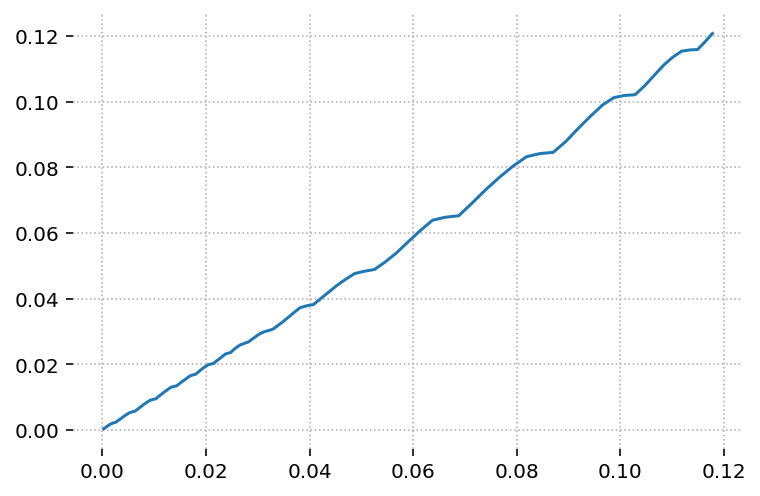

In [1188]:
plt.plot(λ[2].sum(1).cumsum()[:-1], cases_land.loc['Berlin'].cumsum() / capita[2])

n  Growth rate r to ancestor      +/-   \
Lineage                                                
BA.1      84914                   0.077122  0.011244   
BA.1.1    77524                   0.091511  0.016027   
BA.2      13528                   0.154733  0.005643   
BA.3         26                  -0.083121  0.035017   
Other    238716                   0.000000  0.000000   

         Growth rate r to baseline BA.1       +/-  
Lineage                                            
BA.1                           0.000000  0.011244  
BA.1.1                         0.025190  0.016027  
BA.2                           0.086811  0.005643  
BA.3                          -0.246518  0.035017  
Other                         -0.138559  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:875: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


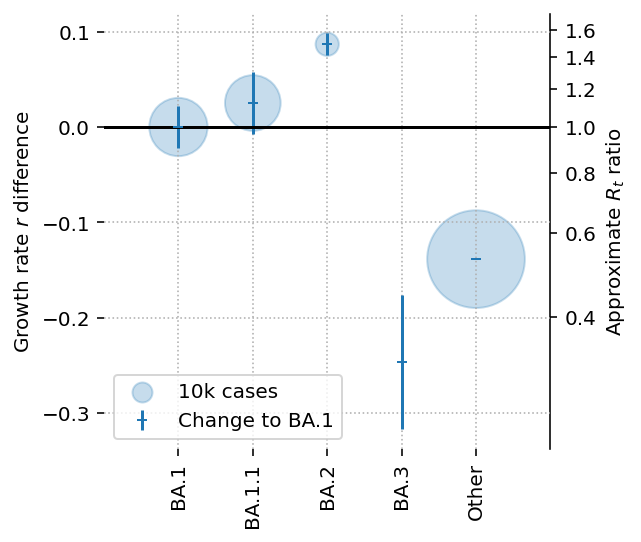

In [1189]:
plt.figure(figsize=(4,4))
plot_growth_rates(model, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")

In [1190]:
import geopandas as gpd

In [1191]:
bl = gpd.read_file("data/bundeslaender.geojson").set_index("bundesland")

In [1192]:
bl

land  \
bundesland                            
Baden-Württemberg       Deutschland   
Bayern                  Deutschland   
Berlin                  Deutschland   
Brandenburg             Deutschland   
Bremen                  Deutschland   
Hamburg                 Deutschland   
Hessen                  Deutschland   
Mecklenburg-Vorpommern  Deutschland   
Niedersachsen           Deutschland   
Nordrhein-Westfalen     Deutschland   
Rheinland-Pfalz         Deutschland   
Saarland                Deutschland   
Sachsen                 Deutschland   
Sachsen-Anhalt          Deutschland   
Schleswig-Holstein      Deutschland   
Thüringen               Deutschland   

                                                                 geometry  
bundesland                                                                 
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...  
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...  
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...  
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...  
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...  
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...  
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...  
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...  
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...  
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...  
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...  
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...  
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...  
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...  
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...  
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...

In [1193]:
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other
bundesland        date                                       
Baden-Württemberg 2021-11-01     0       0     0     0    142
                  2021-11-02     0       0     0     0    350
                  2021-11-03     0       0     0     0    704
                  2021-11-04     0       0     0     0   1044
                  2021-11-05     0       0     0     0   1210
...                            ...     ...   ...   ...    ...
Thüringen         2022-02-08     1       2     0     0      0
                  2022-02-09     0       0     3     0      0
                  2022-02-10     1       1     0     0      0
                  2022-02-11     0       0     0     0      0
                  2022-02-13     0       0     0     0      0

[1664 rows x 5 columns]

In [1194]:
λ.sum(0)[-1] / λ.sum((0,2))[-1]

array([0.22490913, 0.43089419, 0.34146326, 0.00194987, 0.00078355])

In [1195]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


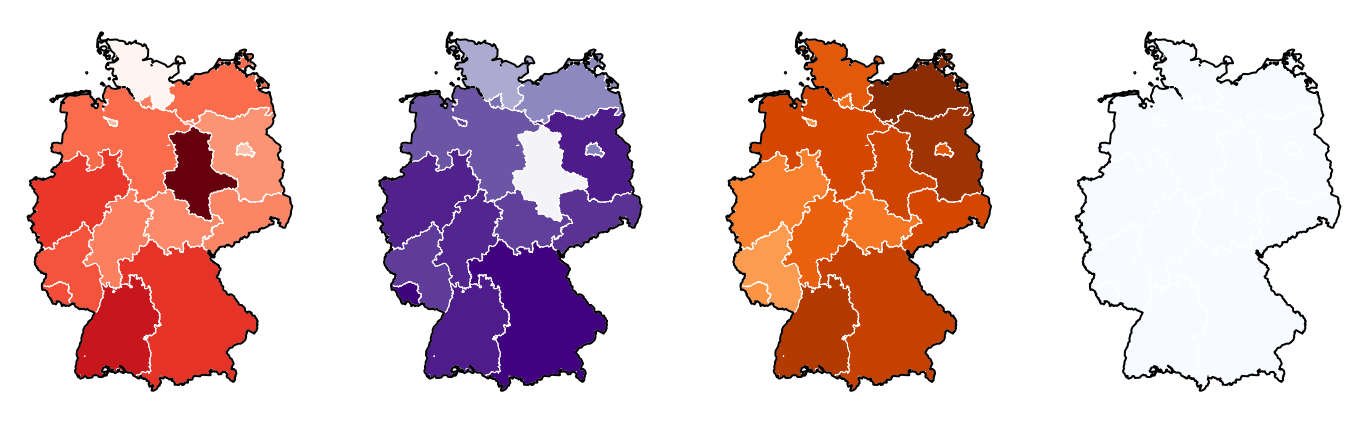

In [1229]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,4, figsize=(12,6))
for ax in axs:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
b0 = bl.copy().merge(pd.DataFrame(λ[:-1,-1,:], columns=genomes.columns, index=bl.index), 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="Reds", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="Purples", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="Oranges",norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="Blues",norm=LogNorm(vmin=vmin, vmax=vmax))
for ax in axs:
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [1237]:
b0.iloc[:,2:] * capita.values.reshape(-1,1)

BA.1        BA.1.1          BA.2        BA.3  \
bundesland                                                                    
Baden-Württemberg       8572.546713  12461.544493  10574.219912    0.098571   
Bayern                  7611.114756  18676.048475  11176.207989    0.000000   
Berlin                   688.526099   1846.121246   2372.963929    0.000000   
Brandenburg              689.274573   2875.123143   2817.569078    1.536369   
Bremen                   137.632128    590.884640    255.886514    0.000000   
Hamburg                  608.196129   1087.987911    933.554329    0.000000   
Hessen                  2031.597489   6584.499228   3667.516861  146.352587   
Mecklenburg-Vorpommern   606.449598    743.081884   2103.299011    0.000000   
Niedersachsen           2993.420490   5776.564018   6156.506107    0.000000   
Nordrhein-Westfalen     9951.106397  19526.838389   7732.201132  382.458262   
Rheinland-Pfalz         1831.794131   3579.105909   1359.779379    0.000000   
Saarland                 461.973754   1387.624985    351.435013    0.000000   
Sachsen                 1241.638484   3876.216001   3095.830138   18.960486   
Sachsen-Anhalt          3176.862937    268.079426   1741.774517    0.686726   
Schleswig-Holstein       260.867192    958.110269   1843.103317   30.323952   
Thüringen                626.622836   1793.324478    977.977975    0.000000   

                            Other  
bundesland                         
Baden-Württemberg       22.249415  
Bayern                  10.097952  
Berlin                   0.724664  
Brandenburg              4.014558  
Bremen                   0.057706  
Hamburg                  1.125709  
Hessen                   2.075475  
Mecklenburg-Vorpommern   5.927024  
Niedersachsen           10.345843  
Nordrhein-Westfalen     13.934390  
Rheinland-Pfalz          5.485402  
Saarland                 0.786730  
Sachsen                  3.904847  
Sachsen-Anhalt          15.165468  
Schleswig-Holstein       1.332834  
Thüringen                5.985427

In [1197]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-5,:]
r

array([[-0.01733513,  0.00696304,  0.06098221, -0.30470384, -0.16712841],
       [-0.02552908, -0.00071593,  0.04823755, -0.17699154, -0.17699154],
       [-0.08952783, -0.05646056, -0.01418474, -0.23003537, -0.23003537],
       [-0.05447151, -0.01763576,  0.04772082, -0.33415023, -0.17985437],
       [-0.0966958 , -0.0725458 , -0.03751155, -0.24839899, -0.24839899],
       [-0.09020246, -0.06316669,  0.0160522 , -0.21217489, -0.21217489],
       [-0.06121357, -0.03257254,  0.02449843, -0.36694014, -0.20414377],
       [-0.04718058, -0.03008214,  0.05196641, -0.17643723, -0.17643723],
       [-0.03994343, -0.01274851,  0.04921399, -0.17842678, -0.17842678],
       [-0.04463083, -0.01299538,  0.03884808, -0.28224509, -0.18917955],
       [-0.03994591, -0.00389705,  0.03601106, -0.18017825, -0.18017825],
       [-0.02883078,  0.00456744,  0.05601939, -0.17201122, -0.17201122],
       [-0.02761621,  0.0049362 ,  0.06395771, -0.27204335, -0.16406448],
       [-0.00701912, -0.04478521,  0.0

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


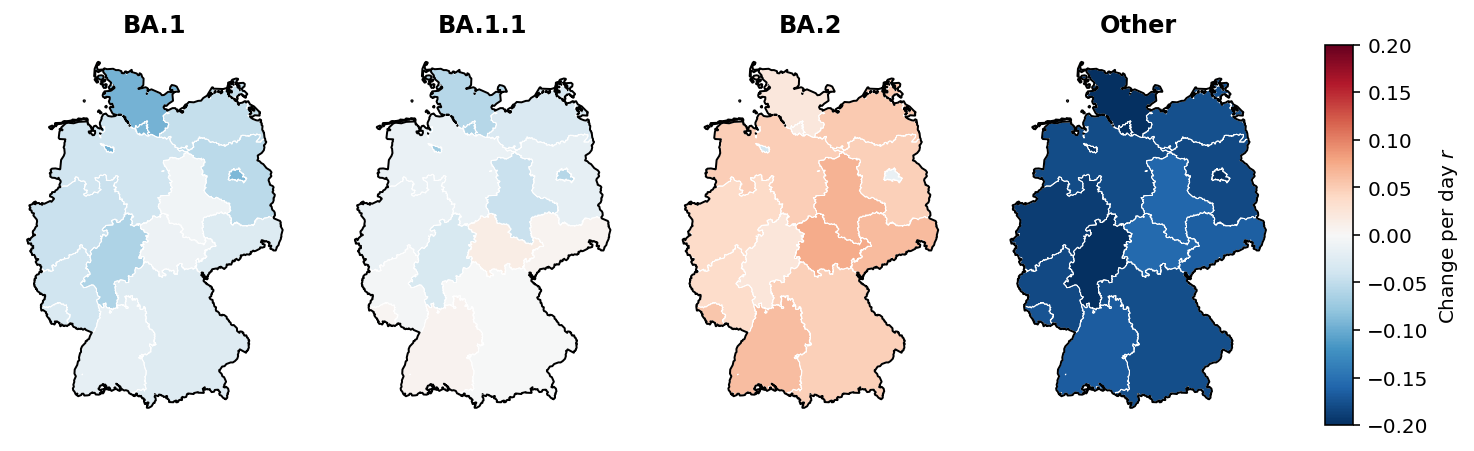

In [1198]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
d = pd.DataFrame(r[:-1,:], columns=genomes.columns, index=bl.index)
#d.loc["Sachsen-Anhalt"]=np.nan
b0 = bl.copy().merge(d, 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="RdBu_r", vmin=-0.2,vmax=0.2, cax=axs[4], legend_kwds={'label': "Change per day $r$", 'pad':0.3}, legend=True, missing_kwds= dict(color = "lightgrey"))# norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#, norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
for i,ax in enumerate(axs[:-1]):
    ax.set_title(genomes.columns[[0,1,2,4]][i], weight='bold')
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [1127]:
d

lineage                     BA.1    BA.1.1      BA.2      BA.3     Other
bundesland                                                              
Baden-Württemberg      -0.011293  0.018171  0.066810 -0.291532 -0.159851
Bayern                 -0.005419  0.022197  0.070753 -0.156051 -0.156051
Berlin                 -0.070297 -0.037860  0.009154 -0.209650 -0.209650
Brandenburg            -0.043326  0.002638  0.052732 -0.321689 -0.171259
Bremen                 -0.061278 -0.034584 -0.001413 -0.212016 -0.212016
Hamburg                -0.087779 -0.069048  0.016639 -0.210362 -0.210362
Hessen                 -0.024536  0.004050  0.052987 -0.329475 -0.168162
Mecklenburg-Vorpommern -0.009001  0.007393  0.068109 -0.159525 -0.159525
Niedersachsen          -0.019778  0.012898  0.066078 -0.160756 -0.160756
Nordrhein-Westfalen    -0.029785  0.002861  0.048819 -0.259282 -0.175458
Rheinland-Pfalz        -0.025487  0.006153  0.051984 -0.170188 -0.170188
Saarland               -0.012246  0.022232  0.064815 -0.156532 -0.156532
Sachsen                -0.008917  0.023110  0.080537 -0.244172 -0.146093
Sachsen-Anhalt               NaN       NaN       NaN       NaN       NaN
Schleswig-Holstein     -0.084834 -0.045748  0.032176 -0.275626 -0.194002
Thüringen               0.009612  0.036373  0.099825 -0.123930 -0.123930

In [115]:
genomes.loc["Rheinland-Pfalz","2022-01-01":,:]

lineage                     BA.1.1  BA.1  BA.2  BA.3  Other
bundesland      date                                       
Rheinland-Pfalz 2022-01-01       0     0     0     0      0
                2022-01-02       0     0     0     0      0
                2022-01-03       0     2     0     0      0
                2022-01-04       0     5     0     0     22
                2022-01-05       0     0     0     0      2
                2022-01-06       0     0     0     0      0
                2022-01-07       0     0     0     0      0
                2022-01-08       0     0     0     0      1
                2022-01-09       0     0     0     0      0
                2022-01-10       0     1     0     0      0
                2022-01-11       0     0     0     0      0
                2022-01-12       0     0     0     0      1
                2022-01-13       0     0     1     0      0
                2022-01-14       0     1     0     0      0
                2022-01-15       0     0     0     0      0
                2022-01-16       0     0     0     0      0
                2022-01-17       0     0     0     0      0
                2022-01-18       0     0     0     0      0
                2022-01-19       0     0     0     0      0
                2022-01-20       0     0     0     0      0
                2022-01-21       0     0     0     0      0
                2022-01-22       0     0     0     0      0
                2022-01-23       0     0     0     0      0
                2022-01-24       0     0     0     0      0
                2022-01-25       0     0     0     0      0
                2022-01-26       0     0     0     0      0

In [116]:
capita.values @ λ[:-1,-1,:]

array([103657.00267258,  93567.99171471,  33828.39373456,   2451.61090274,
         2537.43408102])

In [117]:
(lambda x: x/x.sum(1, keepdims=True))(λ[:,-1,:])

array([[3.73842094e-01, 4.83283873e-01, 1.33117836e-01, 3.30964237e-04,
        9.42523237e-03],
       [4.77723939e-01, 3.35254227e-01, 1.39716323e-01, 4.15601022e-02,
        5.74540875e-03],
       [4.01464060e-01, 4.07470469e-01, 1.87871681e-01, 0.00000000e+00,
        3.19378948e-03],
       [5.16355308e-01, 2.52204762e-01, 2.16802558e-01, 0.00000000e+00,
        1.46373722e-02],
       [7.22478992e-01, 2.75944111e-01, 0.00000000e+00, 0.00000000e+00,
        1.57689784e-03],
       [4.28577408e-01, 4.78027912e-01, 8.83935204e-02, 1.05578645e-03,
        3.94537308e-03],
       [4.44808166e-01, 5.04272585e-01, 4.48851588e-02, 0.00000000e+00,
        6.03409002e-03],
       [3.73161598e-01, 4.05635770e-01, 2.02118520e-01, 0.00000000e+00,
        1.90841114e-02],
       [5.25826950e-01, 2.85654231e-01, 1.76409820e-01, 0.00000000e+00,
        1.21089989e-02],
       [4.64662618e-01, 4.26984320e-01, 1.02916846e-01, 7.25359139e-04,
        4.71085669e-03],
       [2.41412714e-02, 3.3769

In [118]:
from celluloid import Camera
from tqdm import tqdm
from matplotlib import colors


In [ ]:
n = 7
m = (int(λ.shape[1]/7)+1)
fig, axs = plt.subplots(m,n, figsize=(7,10*m/n))
#camera = Camera(fig)
b0 = bl.copy().simplify(1e-1)
axs = axs.flatten()
for ax in axs:
    ax.axis("off")

    
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]
r = colors.colorConverter.to_rgb("C3")
b = colors.colorConverter.to_rgb("C0")
y = colors.colorConverter.to_rgb("C1")

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    ax = axs[i]
        
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()

    alpha = λ[:-1,i,[1,2,4]]/λ.max()
    c = [make_rgb_transparent(y, make_rgb_transparent(r, make_rgb_transparent(b, (1,1,1), x[2]), x[0]), x[1]) for x in alpha]

    ax.set_title((cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=8)
    b0.plot(color=c, ax=ax)

    #bl.boundary.plot(color='w',lw=0.5, ax=ax)
    #de.boundary.plot(color='k',lw=1, ax=ax)
    #camera.snap()


In [ ]:
f"{λ[:-1,-1,1] @ capita.values:0.0f}"

In [ ]:
λ.max()*700

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,10.5), facecolor=None)
camera = Camera(fig)
b0 = bl.copy()#.simplify(1e-2)

ax.axis("off")

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()
    alpha = λ[:-1,i,[1,2,4]]/λ.max()
    c = [make_rgb_transparent(y, make_rgb_transparent(r, make_rgb_transparent(b, (1,1,1), x[2]), x[0]), x[1]) for x in alpha]
    b0.plot(color=c, ax=ax)

    #ax.set_title(cases_land.columns[i].strftime("%-d %b \'%y"), size=12)
    if i == 0:
        ax.set_ylim((None, ax.get_ylim()[0] + 1.05 * (ax.get_ylim()[1]-ax.get_ylim()[0])))
    
    ax.text(0.0, 1.01,  (cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=24, transform=ax.transAxes)
    ax.text(0.6, 1.01,  f"{λ[:-1,i,4] @ capita.values:0.0f}", color = "C0", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 0.96,  f"{λ[:-1,i,1] @ capita.values:0.0f}", color = "C3", size=24, transform=ax.transAxes, ha= 'right')
    ax.text(0.6, 0.91,  f"{λ[:-1,i,2] @ capita.values:0.0f}", color = "C1", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 1.01,  f" Delta cases", color = "C0", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.96,  f" BA.1 cases", color = "C3", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.91,  f" BA.2 cases", color = "C1", size=24, transform=ax.transAxes)

    bl.boundary.plot(color='w',lw=1, ax=ax)
    de.boundary.plot(color='k',lw=2, ax=ax)
    camera.snap()


In [ ]:
animation = camera.animate(interval = 100, blit=True, repeat = False, repeat_delay=1000)

In [ ]:
#import ffmpeg
from IPython.display import HTML
import re
HTML(re.sub("width=\"576\"","width=288",animation.to_html5_video()))

# UK analysis

In [1206]:
import requests
cases_uk = pd.read_csv("https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newCasesBySpecimenDate&format=csv", parse_dates=True, index_col=3)["newCasesBySpecimenDate"].sort_index().loc["2021-11-01":].iloc[:-1]

In [1207]:
cases_uk

date
2021-11-01    45068
2021-11-02    37975
2021-11-03    35933
2021-11-04    33616
2021-11-05    30295
              ...  
2022-02-10    51170
2022-02-11    43557
2022-02-12    36641
2022-02-13    40847
2022-02-14    50907
Name: newCasesBySpecimenDate, Length: 106, dtype: int64

In [1208]:
x = []
c = "United Kingdom"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])

genomes_uk = pd.DataFrame(x).T.fillna(0)#
genomes_uk = genomes_uk.loc[genomes_uk.index <= cases_uk.index.max(),:]
genomes_uk.sum(0)

BA.1          318031.0
BA.1.1        119064.0
BA.2           17724.0
BA.3              14.0
B.1.617.2*    364909.0
dtype: float64

In [1209]:
genomes_uk = genomes_uk[genomes_uk.sum(1) > 100]

In [1210]:
genomes_uk

BA.1  BA.1.1    BA.2  BA.3  B.1.617.2*
date                                                
2021-11-01     0.0     0.0     0.0   0.0      7615.0
2021-11-02     0.0     0.0     0.0   0.0      5970.0
2021-11-03     1.0     0.0     0.0   0.0      7019.0
2021-11-04     0.0     0.0     0.0   0.0      6382.0
2021-11-05     0.0     0.0     0.0   0.0      6839.0
...            ...     ...     ...   ...         ...
2022-02-05  2731.0  3050.0  1549.0   0.0         2.0
2022-02-06  2549.0  2945.0  1444.0   0.0         2.0
2022-02-07  2764.0  3123.0  1494.0   0.0         1.0
2022-02-08  1572.0  1911.0  1203.0   0.0         2.0
2022-02-09   336.0   448.0   285.0   0.0         0.0

[101 rows x 5 columns]

In [1211]:
genomes_uk["BA.1"][:"2021-11-18"] = 0
genomes_uk["BA.1.1"][:"2021-11-18"] = 0
genomes_uk["BA.2"][:"2021-12-18"] = 0

In [1212]:
date_split = np.datetime64("2021-12-14") + np.arange(0,8,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]
#bar[1,genomes_uk.index > d[1],:] = 0
#bar[2,genomes_uk.index <= d[1],:] = 0

In [1213]:
date_split

array(['2021-12-14', '2021-12-28', '2022-01-11', '2022-01-25'],
      dtype='datetime64[D]')

In [1214]:
foo = np.stack((len(date_split)+1) * [cases_uk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_uk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_uk.index > dd,:] = 0
    bar[i+1,genomes_uk.index <= dd,:] = 0


In [1215]:
model_uk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]),
    np.repeat(67.22e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=10.,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=100), 'num_epochs':10000, 'lr':0.05, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [1216]:
model_uk.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

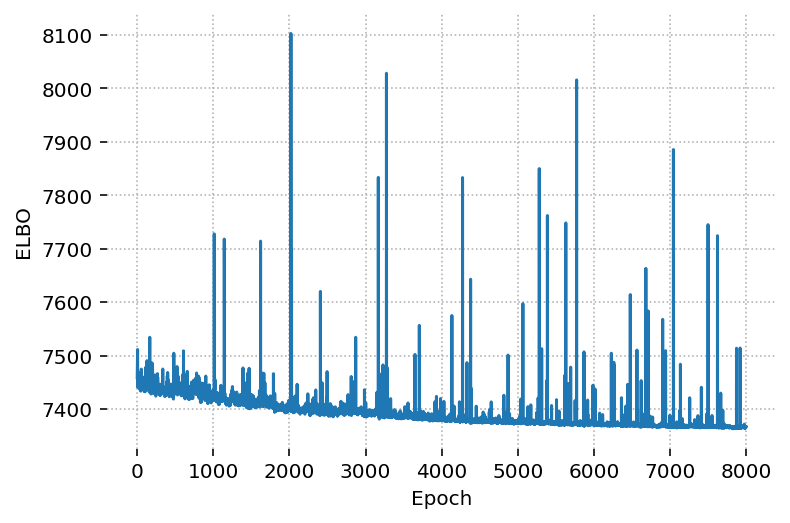

In [1217]:
plt.plot(model_uk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [1218]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

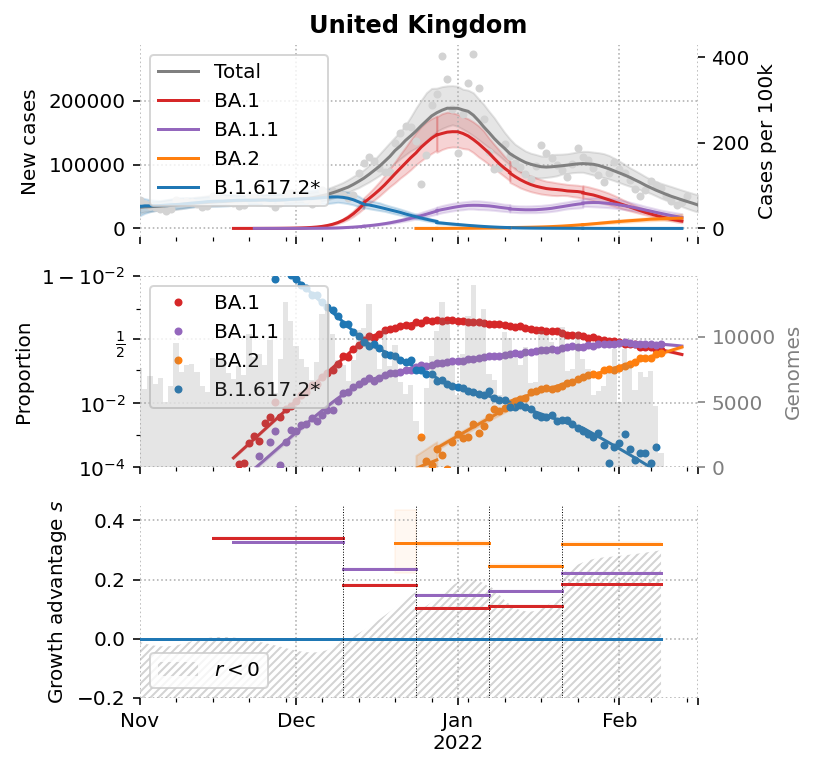

In [1225]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,4]#np.arange(genomes_uk.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_uk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_uk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right= 5 if j == 0 else 1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("United Kingdom", size=12, weight='bold')
#ax[0].set_yscale("log")

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.2,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
#f = ax[2].xaxis.get_major_formatter()
#ax[1].xaxis.set_major_formatter(f)
#ax[1].set_xticklabels(ax[2].get_xticklabels(), visible=True)
#plt.setp(ax[1].get_xticklabels(),visible=True)
#plt.delaxes(ax[3])
#plt.delaxes(ax[0])
#ax[1].xaxis.set_tick_params(labelbottom=True)

#ax[1].xaxis.set_major_formatter(f)


In [1220]:
ax[2].xaxis.

SyntaxError: invalid syntax (<ipython-input-1220-fb3c9b67e0ea>, line 1)

In [ ]:
## import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_uk, genomes_uk.columns.to_list(), color=["C0","None"], baseline="BA.1")


In [73]:
bar.shape

(4, 88, 5)

In [70]:
ax=plt.gcf().get_axes()

<Figure size 432x288 with 0 Axes>

In [71]:
ax

[]

## Germany

In [1199]:
foo = np.stack((len(date_split)+1) * [CC[-1]], axis=0)
bar = np.stack((len(date_split)+1)  * [GG[-1]], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes.index.levels[1] > dd + np.timedelta64(2,"D"),:] = 0
    bar[i+1,genomes.index.levels[1] < dd - np.timedelta64(1,"D"),:] = 0
bar[0,:,2] = 0

In [1200]:
model_de = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    seq_index,
    np.repeat(capita.values.sum().reshape(1),len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [1201]:
model_de.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

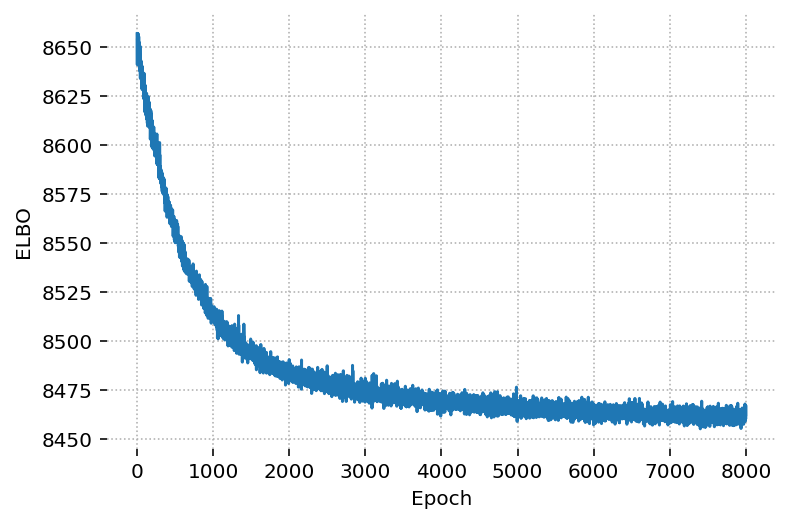

In [1202]:
plt.plot(model_de.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [1203]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

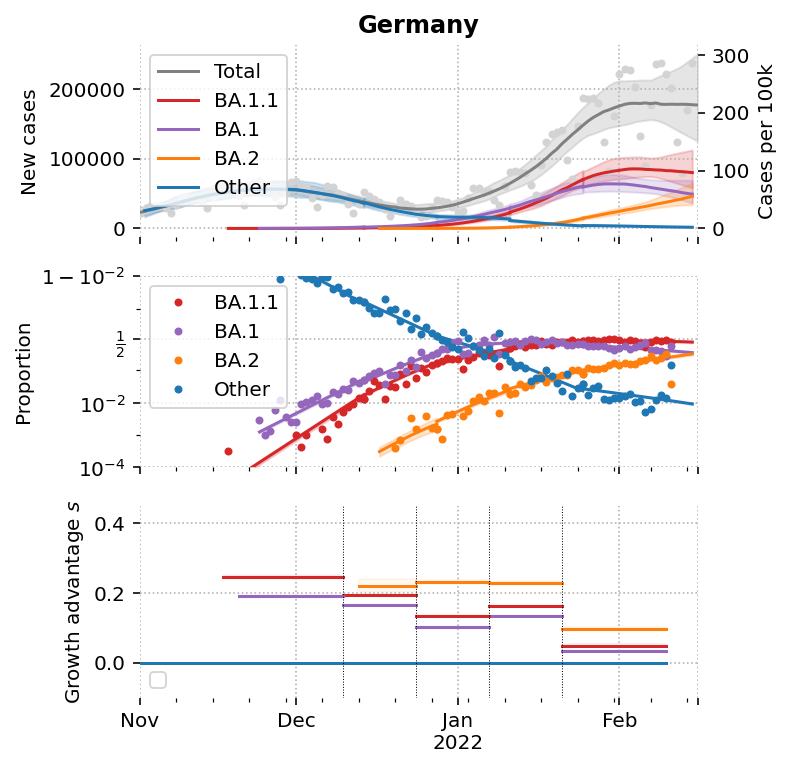

In [1227]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [1,0,2,4]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_de, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C4','C3', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = -1,
             bleed_right= 5 if j == 0 else -1,
             show_Rt = False,
             plot_s= True,
             plot_r = False
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Germany", size=12, weight='bold')

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])



n  Growth rate r to ancestor      +/-   \
Lineage                                                
BA.1      57167                   0.014253  0.054516   
BA.1.1    51529                   0.016819  0.065526   
BA.2       8381                   0.029725  0.056628   
BA.3         15                   0.007603  0.105886   
Other    138443                   0.000000  0.000000   

         Growth rate r to baseline BA.1       +/-  
Lineage                                            
BA.1                           0.000000  0.054516  
BA.1.1                         0.031689  0.065526  
BA.2                           0.070333  0.056628  
BA.3                          -0.064255  0.105886  
Other                         -0.124918  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:875: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


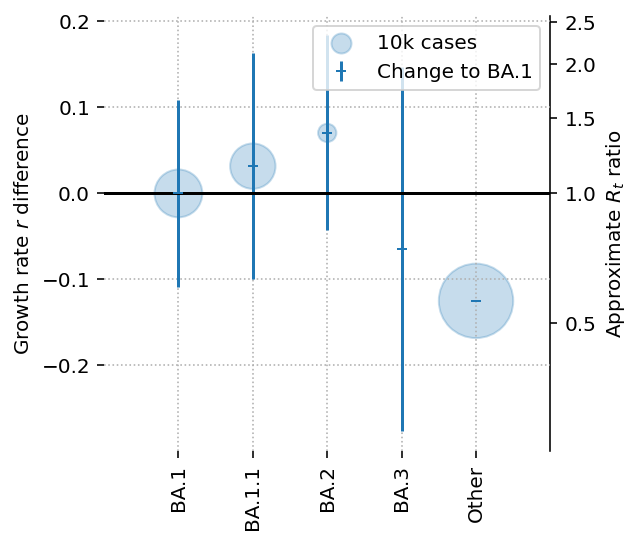

In [1205]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_de, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")


## Denmark

In [365]:
cases_dk = pd.read_csv("../overvaagningsdata-dashboard-covid19-31012022-40ip/Regionalt_DB/08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv", index_col=[0,1],parse_dates=True, encoding='latin_1', sep=";").sum(level=1).loc["2021-11-01":].iloc[:-1,0]

In [366]:
cases_dk

Dato
2021-11-01     2191
2021-11-02     2313
2021-11-03     2295
2021-11-04     2340
2021-11-05     2205
              ...  
2022-01-26    41724
2022-01-27    39088
2022-01-28    35946
2022-01-29    28186
2022-01-30    12808
Name: Bekræftede tilfælde, Length: 91, dtype: int64

In [367]:
x = []
c = "Denmark"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    try:
        x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])
    except:
        pass


genomes_dk = pd.DataFrame(x).T.fillna(0)#
genomes_dk = genomes_dk.loc[genomes_dk.index <= cases_dk.index.max(),:]
genomes_dk.sum(0)

BA.1          27372.0
BA.1.1         2779.0
BA.2          20130.0
B.1.617.2*    81370.0
dtype: float64

In [409]:
date_split = np.datetime64("2021-12-14") + np.arange(0,6,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]

In [410]:
foo = np.stack((len(date_split)+1) * [cases_dk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_dk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_dk.index > dd,:] = 0
    bar[i+1,genomes_dk.index <= dd,:] = 0


In [411]:
model_dk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_dk.index.to_list().index(i) for i in genomes_dk.index]),
    np.repeat(5.831e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.1,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':12000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [412]:
foo.shape

(4, 91)

In [413]:
model_dk.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 12,000 | 0 %
SVI step 1,000 / 12,000 | 8 %
SVI step 2,000 / 12,000 | 17 %
SVI step 3,000 / 12,000 | 25 %
SVI step 4,000 / 12,000 | 33 %
SVI step 5,000 / 12,000 | 42 %
SVI step 6,000 / 12,000 | 50 %
SVI step 7,000 / 12,000 | 58 %
SVI step 8,000 / 12,000 | 67 %
SVI step 9,000 / 12,000 | 75 %
SVI step 10,000 / 12,000 | 83 %
SVI step 11,000 / 12,000 | 92 %


Text(0, 0.5, 'ELBO')

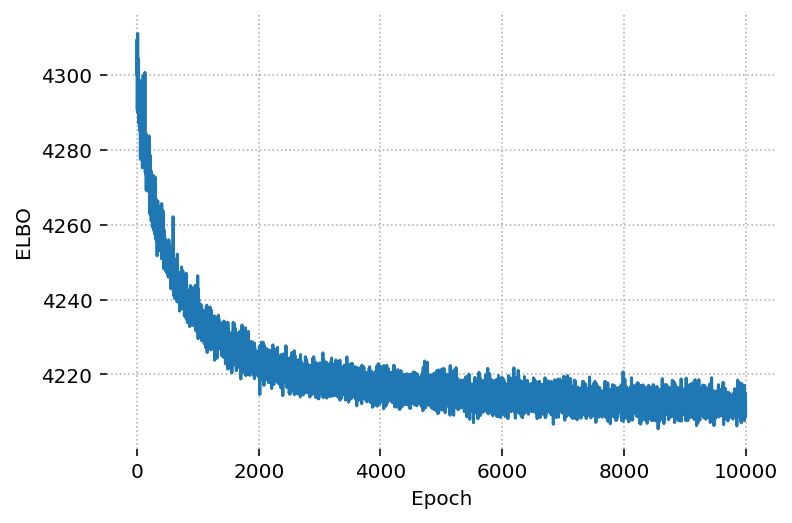

In [414]:
plt.plot(model_dk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [626]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

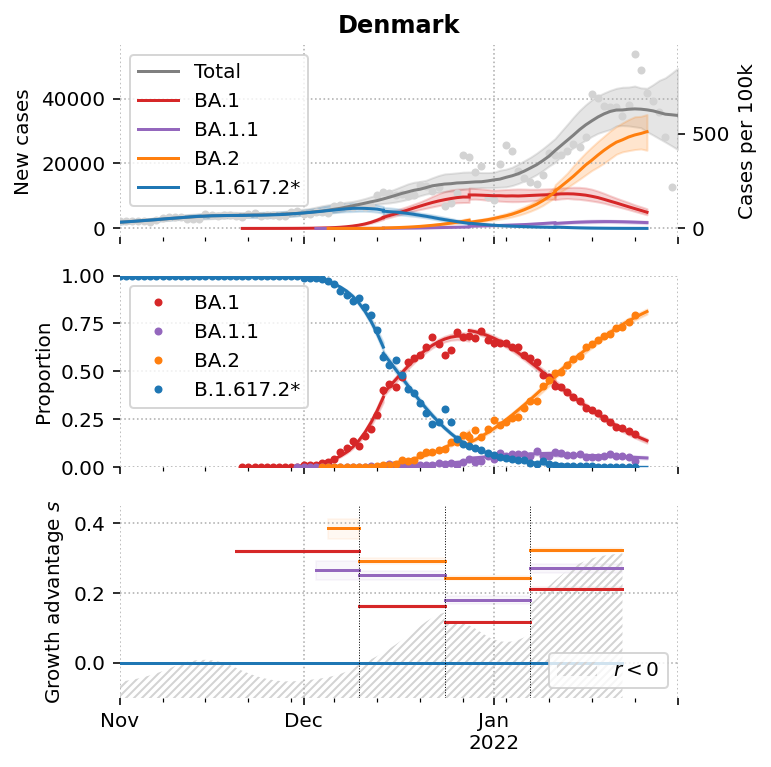

In [647]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,3]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_dk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_dk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C0", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right=3 if j ==0 else 1,
             show_Rt = False,
             plot_s= True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Denmark", size=12, weight='bold')

#ax[1].set_yscale("logit")
#ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend().remove()
ax[1].legend(facecolor='white')
ax[2].legend(loc='lower right')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])


In [428]:
(bar[-1,-15:] )

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [6.890e+02, 1.210e+02, 8.140e+02, 1.400e+01],
       [7.870e+02, 1.250e+02, 1.064e+03, 1.800e+01],
       [7.440e+02, 1.260e+02, 1.155e+03, 1.100e+01],
       [5.490e+02, 1.100e+02, 9.180e+02, 8.000e+00],
       [4.300e+02, 7.600e+01, 8.650e+02, 7.000e+00],
       [6.010e+02, 1.080e+02, 1.303e+03, 1.000e+01],
       [6.290e+02, 1.200e+02, 1.481e+03, 8.000e+00],
       [4.950e+02, 1.110e+02, 1.325e+03, 5.000e+00],
       [3.900e+02, 1.160e+02, 1.155e+03, 3.000e+00],
       [4.050e+02, 1.120e+02, 1.390e+03, 3.000e+00],
       [3.260e+02, 9.800e+01, 1.167e+03, 4.000e+00],
       [9.200e+01, 2.600e+01, 3.700e+02, 1.000e+00],
       [4.500e+01, 8.000e+00, 2.040e+02, 0.000e+00]])

In [209]:
genomes_dk

BA.1  BA.1.1    BA.2  B.1.617.2*
date                                         
2021-11-01    0.0     0.0     0.0      1232.0
2021-11-02    0.0     0.0     0.0      1605.0
2021-11-03    0.0     0.0     0.0      1760.0
2021-11-04    0.0     0.0     0.0      1540.0
2021-11-05    0.0     0.0     0.0      1641.0
...           ...     ...     ...         ...
2022-01-20  390.0   116.0  1155.0         3.0
2022-01-21  405.0   112.0  1390.0         3.0
2022-01-22  326.0    98.0  1167.0         4.0
2022-01-23   92.0    26.0   370.0         1.0
2022-01-24   45.0     8.0   204.0         0.0

[85 rows x 4 columns]

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1        27372                   0.036938  0.074269   
BA.1.1       2779                   0.052333  0.019801   
BA.2        20130                   0.037401  0.020701   
B.1.617.2*  81370                   0.000000  0.000000   

            Growth rate r to baseline BA.1       +/-  
Lineage                                               
BA.1                              0.000000  0.074269  
BA.1.1                            0.023355  0.019801  
BA.2                              0.086703  0.020701  
B.1.617.2*                       -0.186289  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:868: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


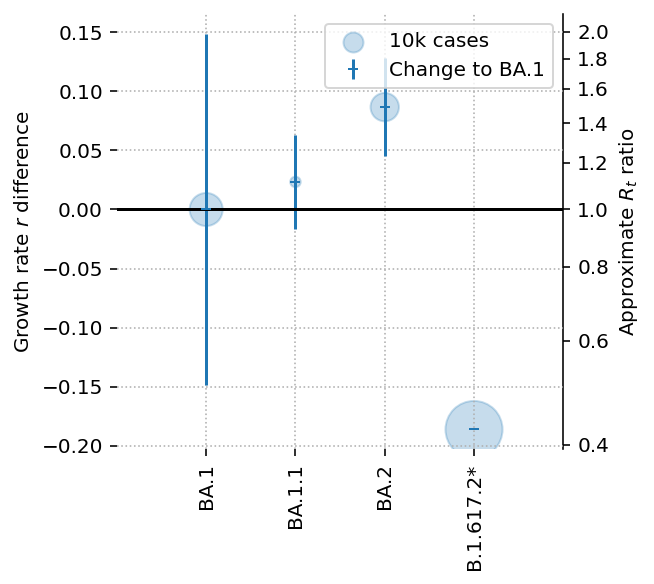

In [215]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_dk, genomes_dk.columns.to_list(), color=["C0","None"], baseline="BA.1")
